In [1]:
from symreg import Regressor
import pandas as pd
import numpy as np
import random

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
X, y = load_boston(return_X_y=True)
y /= y.max()
X, Xt, y, yt = train_test_split(X, y, test_size=0.4, random_state=0)

results = []
Xt.shape

(203, 13)

In [ ]:
diff_data, same_data, duration_per = 360, 1, 5 # 30 minutes
# diff_data, same_data, duration_per = 180, 1, 5 # 15 minutes
# diff_data, same_data, duration_per = 120, 1, 1 # 1 minute
# diff_data, same_data, duration_per   = 4, 3, .1 # instant


def time_left(diff_data):
    return f'{diff_data * same_data * duration_per / 60} minutes'

print(f'Will take {time_left(diff_data)}')

def eval_settings(**settings):
    print()
    r = Regressor(duration=duration_per, verbose=True, **settings)
    r.fit(X, y)
    
    y_out = r.predict(Xt)
    error = np.median((yt - y_out) ** 2)
    return {**settings, **{'error': error}}


for i in range(diff_data):
    muts = [random.random(), random.random(), random.random()]
    muts = [m/sum(muts) for m in muts]
    # muts[0] is pointwise mutation; used only for normalization
    
    args = {
        'n': random.choice([10, 20, 35, 50, 100, 150, 250]),
        'zero_program_chance': random.random(),
        'grow_root_mutation_chance': muts[1],
        'grow_leaf_mutation_chance': muts[2],
        'int_std': random.choice([.1, .2, .3, .5, .8, 1.3, 2.1, 3.4, 5.5, 8.9, 14.4]),
        'float_std': random.choice([.1, .2, .3, .5, .8, 1.3, 2.1, 3.4, 5.5, 8.9, 14.4]),
    }
    
    datas = []
    for _ in range(same_data):
        datas.append(eval_settings(**args))
    s = sorted(datas, key=lambda x: x['error'])
    results.append(s[same_data//2])
    print(results[-1])
    print('------------', time_left(diff_data - i-1), 'left')
    print()

In [4]:
pd.DataFrame(results).sort_values('error').to_csv('metaopt.tsv', sep='\t', index=False)

In [24]:
resdf = pd.read_csv('metaopt.tsv', sep='\t').sort_values('error').dropna()

X2 = resdf.iloc[:, :-1]
y2 = resdf.iloc[:, -1]
X2 /= X2.max()
y2 /= y2.max()
r2 = Regressor(n=50, duration=10, verbose=True)
r2.fit(X2.values, y2.values)

print("\nDone!\n\n")

for p in r2.results():
    print(p)
resdf

Time left  : 5s
Best so far: (0.013310002751555685, 29) (error, complexity)
Generations evolved: 1705

Done!


{'error': 0.015763334964463627, 'complexity': 1, 'program': Program('0.30590493647777595', 6)}
{'error': 0.01574957541004244, 'complexity': 3, 'program': Program('add 0.004309839269047481 0.2975108140891597', 6)}
{'error': 0.01574946549923094, 'complexity': 4, 'program': Program('pow exp -1.1511968784689857 1.0391737856471317', 6)}
{'error': 0.01530080586324725, 'complexity': 5, 'program': Program('div -2 sub -6.094150935574751 $3', 6)}
{'error': 0.01458612480548016, 'complexity': 7, 'program': Program('div 1 add 1.8728073598489428 pow 3.377154310491382 $3', 6)}
{'error': 0.013981816658324412, 'complexity': 9, 'program': Program('div 1 add add 1.6807908268816645 $0 pow 3 $3', 6)}
{'error': 0.013666970543505054, 'complexity': 11, 'program': Program('div 1 add add div 1.6807908268816645 1.150909827456379 $0 pow 4 $3', 6)}
{'error': 0.013610168465360754, 'complexity': 15, 'progra

,n,zero_program_chance,grow_root_mutation_chance,grow_leaf_mutation_chance,int_std,float_std,error
0,10,0.646718,0.193154,0.468956,8.9,0.3,0.165661
1,35,0.672573,0.209245,0.423587,1.3,1.3,0.169260
2,50,0.317607,0.288420,0.388196,0.5,14.4,0.170345
3,20,0.052365,0.246835,0.566046,2.1,3.4,0.171194
4,50,0.898775,0.294139,0.338331,0.3,0.3,0.172685
...,...,...,...,...,...,...,...
345,10,0.383291,0.352859,0.015876,8.9,0.5,0.748292
346,10,0.106799,0.395952,0.016971,2.1,0.5,0.753943
347,20,0.183338,0.180185,0.118347,2.1,2.1,0.770017
348,20,0.474143,0.631429,0.011579,0.5,1.3,0.782979


# Conclusions

~~~~It seems that the programs taking input into account (starting at the one of complexity 8, which uses `$2` - the `grow_root_mutation_chance`) do not explain much more of the error compared to ones that don't.~~~~

~~~~In the current run, complexity 7 does not use any argument (so is actually a constant), but has an error very close to complexity 8: 0.0157 vs. 0.0154. This tells us that the variables are not very influential.~~~~

I accidentally ran the evolution again, so the details in my comments no longer apply. But the programs still have a large error (almost as large as predicting constant values).

Still, let's plot some programs for demonstration purposes.

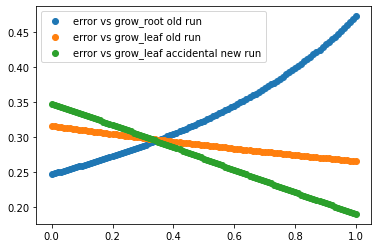

In [30]:
from matplotlib import pyplot as plt
from ga import Program

funx = np.linspace(0, 1, 101)
funy7 = Program('div 1 add 1.8728073598489428 pow 3.377154310491382 $0', 1).eval([funx]) # no need for params
funy8 = Program('pow div 0.44836698212884213 add neg $0 2 0.9342499062909196', 1).eval([funx])
funy10 = Program('div div div 0.14243585764379751 0.14243585764379751 exp -0.511369267917155 add 5.274978097694874 $0', 1).eval([funx])

plt.scatter(funx, funy8, label='error vs grow_root old run')
plt.scatter(funx, funy10, label='error vs grow_leaf old run')
plt.scatter(funx, funy7, label='error vs grow_leaf accidental new run')
plt.legend()
plt.show()

As you can see, the algorithm picked up on some correlations, but whether they're spurious can only be proven after further experimentation. It seems that between 2 runs on the same data, they vary quite significantly (the green vs. orange line).

Still, we have to pick some parameters. We ended up using roughly the mean values of the top 30 individuals from the spreadsheet.